# Separazione di immagini Cifar10

#Preparazione dei dati

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [ ]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [ ]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data

Instanziamo un generatore su Cifar10 con batchsize=1, e testiamone il comportamento.

In [ ]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: deer, second = horse


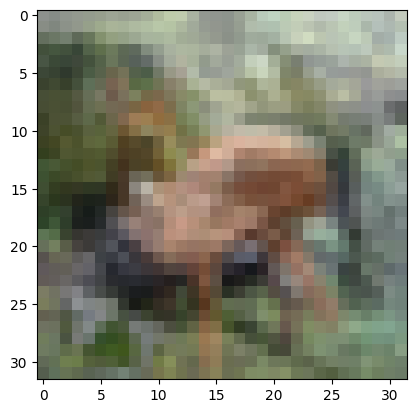

In [ ]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# **Modello (SAS) e Training**
Ho chiamato il mio modello SAS (Shared and Separated), ispirandomi alla sua
struttura.

Il modello presenta una parte convolutiva iniziale in cui si ha Feature Extraction condivisa.
In seguito si hanno dei blocchi convolutivi separati per lo specifico output, e poi si usa GAP e si combinano i risultati per passare ai layer densi.
Anche nei layer densi si ha una parte condivisa, e poi una parte di layer densi separati per ciascun output finale.

Accuratezza dell'80/81% per un numero di parametri abbastanza ridotto (1 milione).

Questo modello è un buon mix tra eleganza, grandezza e accuratezza.

In [ ]:
def SAS_model():
  input_layer = layers.Input(shape=(32, 32, 3))

  # Shared feature extraction
  x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)

  x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)

  x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)

  # Separated conv blocks for each output (extracting image-specific features)
  x1 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x1)
  x1 = layers.BatchNormalization()(x1)
  x1 = layers.MaxPool2D(pool_size=(2, 2))(x1)
  x1 = layers.Dropout(0.25)(x1)

  x2 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.MaxPool2D(pool_size=(2, 2))(x2)
  x2 = layers.Dropout(0.25)(x2)

  # GlobalAveragePooling instead of Flatten (tested and accuracy is around the same, with less parameters)
  gap1 = layers.GlobalAveragePooling2D()(x1)
  gap2 = layers.GlobalAveragePooling2D()(x2)

  # Concatenate GAP outputs
  combined = layers.Concatenate()([gap1, gap2])

  # Shared Dense layer
  shared_dense = layers.Dense(256, activation='relu')(combined)
  shared_dense = layers.Dropout(0.25)(shared_dense)

  # Two separate dense layers for predictions
  output_1 = layers.Dense(128, activation='relu')(shared_dense)
  output_1 = layers.Dropout(0.25)(output_1)
  output_1 = layers.Dense(5, activation='softmax', name='output_1')(output_1)

  output_2 = layers.Dense(128, activation='relu')(shared_dense)
  output_2 = layers.Dropout(0.25)(output_2)
  output_2 = layers.Dense(5, activation='softmax', name='output_2')(output_2)

  model = Model(inputs=input_layer, outputs=[output_1, output_2])
  return model

In [ ]:
model = SAS_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 32, 32, 32)     │            128 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 32)     │            128 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 16, 16, 32)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16, 16, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 16, 16, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 8, 8, 64)       │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 8, 8, 128)      │            512 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 1,014,058 (3.87 MB)

 Trainable params: 1,012,138 (3.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
    metrics={'output_1': 'accuracy', 'output_2': 'accuracy'},
    loss_weights={'output_1': 1.0, 'output_2': 1.0}
)

In [ ]:
import math
batch_size = 32
train_gen = datagenerator(cifar10_x_train_1, cifar10_x_train_2, cifar10_y_train_1, cifar10_y_train_2, batch_size)
steps_per_epoch = math.ceil(cifar10_x_train_1.shape[0] / batch_size)

In [ ]:
model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=600,
    verbose=1
)

Epoch 1/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 3.0022 - output_1_accuracy: 0.3304 - output_1_loss: 1.5222 - output_2_accuracy: 0.3713 - output_2_loss: 1.4800
Epoch 2/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.6049 - output_1_accuracy: 0.4276 - output_1_loss: 1.3474 - output_2_accuracy: 0.4948 - output_2_loss: 1.2575
Epoch 3/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.4249 - output_1_accuracy: 0.4471 - output_1_loss: 1.3044 - output_2_accuracy: 0.5616 - output_2_loss: 1.1205
Epoch 4/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.2856 - output_1_accuracy: 0.4818 - output_1_loss: 1.2480 - output_2_accuracy: 0.6043 - output_2_loss: 1.0376
Epoch 5/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.1680 - output_1_accuracy: 0.5104 - output_1_loss: 1.1930 - output_2_accuracy: 0.6317 - output_2_loss: 0.9751
Epoch 6/600
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.0923 - output_1_accuracy: 0.5330 - output_1_loss: 1.1485 - output_2_accuracy

# Valutazione

Definiamo innanzi tutto il generatore di testing.

In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)
print(eval_samples_y[0].shape)

(10000, 32, 32, 3)
(10000, 5)


In [ ]:
def eval_model(model):
    eval_samples_x, eval_samples_y = next(testgen)
    guesses = model(eval_samples_x)

    output_1_guesses = guesses[0]
    output_2_guesses = guesses[1]

    correct_guesses_1 = np.argmax(output_1_guesses, axis=1) == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = np.argmax(output_2_guesses, axis=1) == np.argmax(eval_samples_y[1], axis=1)

    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

In [ ]:
eval_model(model)

0.80785

let us repeat the evaluation ten times, and compute the standard deviation

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.8056000000000001
standard deviation =  0.0020624015128000734
